**NB this notebooks runs in Python 3.6**

### Objective

This notebook shows how to use the `error_flag` function in Bruges' Petrophysics to evaluate the prediction performance of various processes in a more (hopefully) insightfull way. 

I've used this method before, and had a working Jupyter notebook, which was turned into a fully functional tool for `Bruges` at the [at the 2018 Geophysics Sprint](https://mycarta.wordpress.com/2019/02/07/geophysics-python-sprint-2018-day-2-and-beyond-part-ii).

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import numpy as np
import scipy as sp
from scipy import interpolate
from itertools import groupby
import seaborn as sns
from skimage import io

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

### The math: function to make error flag

The function calculates the difference between a predicted and a real curve, then flags errors in prediction if the difference between the curves exceeds a user-defined distance (in standard deviation units) from the mean difference (default method) and optionally if the curves have opposite slopes (for example one increasing, the other decreasing within a specific interval). The result is a binary error log that can then be used to generate QC plots, to evaluate the performance of the prediction processes in a more (it is my hope) insightful way.

The inspiration for this stems from a discussion over coffee I had 5 or 6 years ago with Glenn Larson, a Geophysicist at Devon Energy, about the limitations of (and alternatives to) using a single global score/error (in that case it was R^2) when evaluating the result of seismic inversion against wireline well logs (the ground truth).

In [3]:
def error_flag(pred, actual, dev = 1.0, method = 1):
    """Calculate the difference between a predicted and an actual curve 
    and return a log flagging large differences based on a user-defined distance 
    (in standard deviation units) from the mean difference

    Matteo Niccoli, October 2018
    
    Args:
        predicted (ndarray) = predicted log
        actual (ndarray) =  original log  
        dev  (float) = standard deviations to use, default 1
        error calcluation method (int), default 1
            1: difference between curves larger than mean difference plus dev
            2: curve slopes have opposite sign
            3: curve slopes of opposite sign OR difference larger than mean plus dev
    

    Returns:
    flag (ndarray) =  error flag curve
    """   
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    ss = np.sign(pred.diff().fillna(pred))
    ls = np.sign(actual.diff().fillna(actual))

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_mean + (dev*err_std)), (ss+ls)==0 ))]= 1
    return flag


### First example (evaluate curve fitting): error in prediction of velocity log from density using inverse Gardner

I will use the result from Alessandro Amato del Monte's [Inverse Gardner Notebook](https://github.com/aadm/geophysical_notes/blob/master/inverse_gardner.ipynb), where he shows how to econstruct a velocity log from density log using optimized alpha and beta parameters for his inverse gardner function, found via `scipy.curve_fit`.

In [4]:
logs1 = pd.read_csv('../data/aadm_gardner.csv')
logs1.describe()

,depth,gr,vp_hole,vp_no_hole,vp_gardner,vp_rebuilt
count,4117.000000,4117.000000,3789.000000,4117.000000,328.000000,4117.000000
mean,2326.892000,72.785125,3037.046267,2984.389630,2361.049371,2983.189822
std,181.145666,14.464120,423.877490,444.671505,51.245128,446.180764
min,2013.252800,48.368700,1439.900000,1439.900000,2238.841631,1439.900000
25%,2170.072500,60.683100,2736.700000,2611.300000,2322.305286,2609.000000
50%,2326.892100,68.026600,3074.800000,3038.158346,2356.921449,3038.158346
75%,2483.711700,83.557200,3263.700000,3251.100000,2403.044013,3251.100000
max,2640.531200,136.512800,4431.000000,4431.000000,2515.005238,4431.000000


**NB The block below breaks down with Python 3.7. Needs to be adjusted so the indexing/slicing works**

In [5]:
hole=((logs1.depth>2075) & (logs1.depth<2125))
flag = np.zeros(len(logs1.vp_rebuilt))
flag[hole] = error_flag(logs1.vp_rebuilt[hole], logs1.vp_no_hole[hole],  1)

In the figure below, reproduced from Alessandro's notebook, the velocity log with the missing data is displayed together with the reconstructed portion (respectively black and red curves) in the middle plot; the right plot displays a comparison between the fully-rebuilt velocity log (black curve) and the original log as it was recorded before artificially creating a gap in it (cyan curve).

I  added red color fill between the predicted and reconstructed original according to the error flag and also an extra track with the error flag on its own.

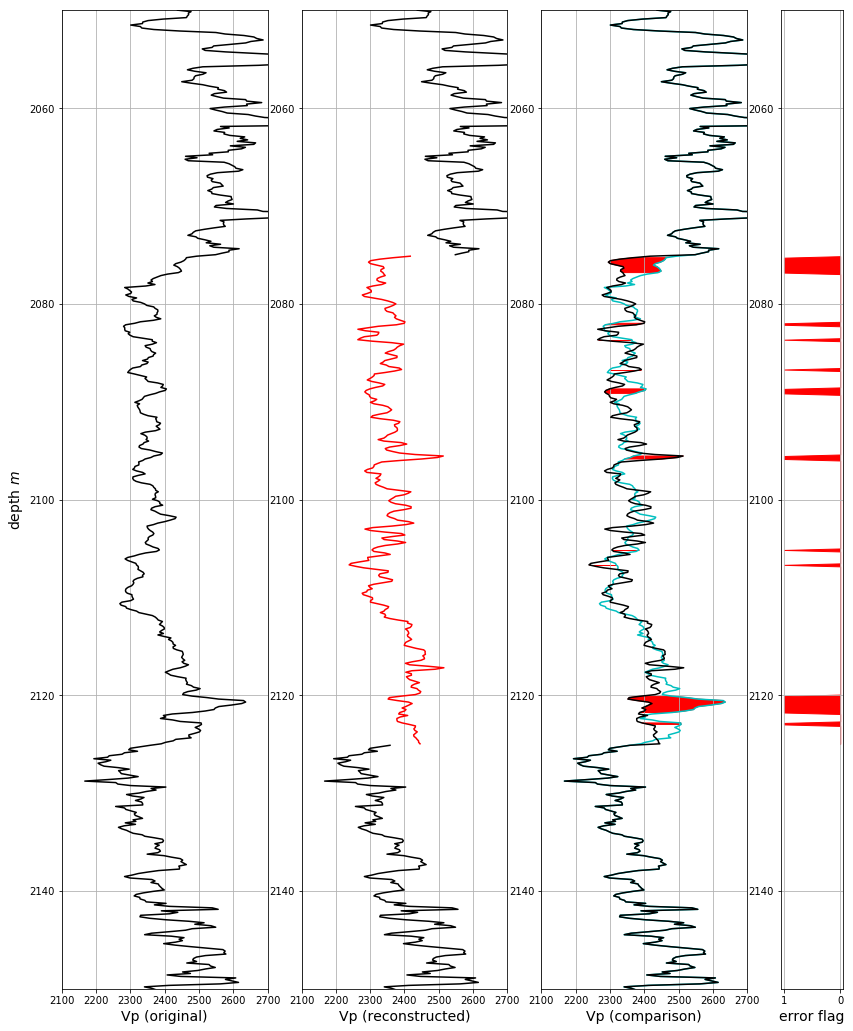

In [6]:
mi = 2100
ma = 2700
fig = plt.figure(figsize=(14,18))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.3]) 

ax = plt.subplot(gs[0])
ax.plot(logs1.vp_no_hole, logs1.depth,'-k')
ax.set_xlabel('Vp (original)', size=14)
ax.set_xlim(mi, ma)
ax.set_ylim(2150,2050)
ax.set_ylabel(r'depth $m$', size=14)
ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs1.vp_hole, logs1.depth,'-k')
ax1.plot(logs1.vp_gardner, logs1.depth,'-r')
ax1.set_xlabel('Vp (reconstructed)', size=14)
ax1.set_xlim(mi, ma)
ax1.set_ylim(2150,2050)
ax1.grid()

ax2 = plt.subplot(gs[2])
ax2.plot(logs1.vp_no_hole, logs1.depth,'-c')
ax2.plot(logs1.vp_rebuilt, logs1.depth,'-k')
ax2.fill_betweenx(logs1.depth[hole], logs1.vp_no_hole[hole],  logs1.vp_rebuilt[hole], where=flag[hole]==1,   color = 'r', label='error flag')
ax2.set_xlabel('Vp (comparison)', size=14)
ax2.set_xlim(mi, ma)
ax2.set_ylim(2150,2050)
ax2.grid()

ax3 = plt.subplot(gs[3])
ax3.fill_betweenx(logs1.depth[hole], flag[hole], 0, color = 'r')
ax3.invert_yaxis()
ax3.invert_xaxis()
ax3.set_xlabel('error flag', size=14)
ax3.set_ylim(2150,2050)
ax3.grid();

### Second example (evaluate Machine Learning model): error in prediction of velocity log from gamma, neutron, density logs using linear regression model

I will use the latest result from MyCarta's [Geoscience ML notebook 6](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_6.ipynb). This is an evolving notebook in which I evaluate and compare the performance of different ML methods in predicting a geophysical log from a suite of other logs. THe current result is prediction of compressional sonic log using a linear model and the Gamma Ray, Neutron Porosity, and Bulk Density logs.

In [7]:
logs2 = pd.read_csv('../data/logs2.csv')
logs2.describe()

,DEPTH,ZONE_NUM,VP,predictedVP
count,4115.000000,4115.000000,4115.000000,4115.000000
mean,2325.675324,4.383718,2974.608233,2974.676073
std,181.053325,2.154977,433.228662,418.308545
min,2013.410000,0.000000,2046.660000,2111.090000
25%,2168.930000,4.000000,2607.125000,2675.275000
50%,2325.670000,4.000000,3050.280000,3029.160000
75%,2482.415000,5.000000,3248.900000,3242.245000
max,2639.160000,9.000000,4088.760000,4049.990000


Original versus predicted sonic, as scatter plot mimicking lines. This is your typical QC plot.

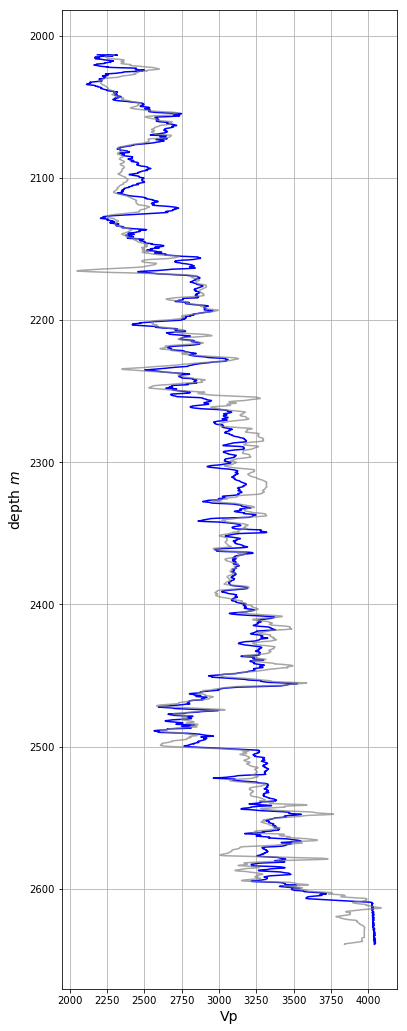

In [8]:
fig = plt.figure(figsize=(6,18))
ax1 = fig.add_subplot(111)
ax1.plot( logs2["predictedVP"], logs2["DEPTH"],'b')
ax1.plot( logs2["VP"], logs2["DEPTH"],'gray', alpha=0.7)
ax1.invert_yaxis()
ax1.grid()
ax1.set_ylabel(r'depth $m$', size=14)
ax1.set_xlabel('Vp', size=14);

In [9]:
flag = error_flag(logs2["predictedVP"], logs2["VP"], 1)

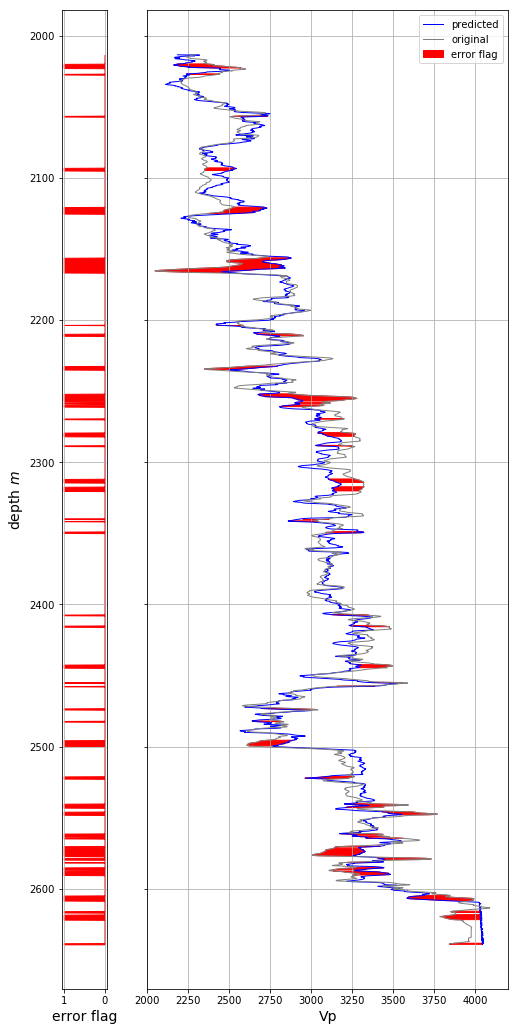

In [10]:
fig = plt.figure(figsize=(8, 18))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.5, 4]) 

ax = plt.subplot(gs[0])
ax.set_ylabel(r'depth $m$', size=14)
ax.fill_betweenx(logs2['DEPTH'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=14)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs2["predictedVP"], logs2["DEPTH"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["VP"], logs2["DEPTH"], 'gray', label='original', linewidth = 1)
ax1.fill_betweenx(logs2['DEPTH'], logs2["predictedVP"], logs2["VP"], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('Vp', size=14)
ax1.set_xlim(2000,4200)
ax1.legend()   
ax1.grid();


##### Bonus: adding a reservoir flag

Load compilation of tops. Source:

http://factpages.npd.no/FactPages/Default.aspx?nav1=wellbore&nav2=PageView|Exploration|All&nav3=2635&culture=en

In [11]:
tops = pd.read_csv('../data/qsi_well2_tops.csv')
tops

,depth,name,id
0,1807,UNDEFINED,0
1,2027,BALDER,1
2,2076,SELE,2
3,2127,LISTA,3
4,2154,HEIMDAL,4
5,2183,OWC,5
6,2458,LISTA,6
7,2491,VALE,7
8,2501,TY,8
9,2583,VALE,9


Get reservoir top and bottom depths

In [12]:
top1 = np.float64(tops.loc[tops['name']=='HEIMDAL', ['depth']].values[0]) # top of Heimdal sand
top2 = np.float64(tops.loc[tops['name']=='OWC', ['depth']].values[0]) # Oil-Water Contact
#print(top1, top2)

In [13]:
oil = np.zeros(len(logs2["DEPTH"]))
logs2['oil_zone']=oil
logs2.loc[(logs2["DEPTH"]>top1) & (logs2["DEPTH"]<top2), 'oil_zone']= 1
logs2.describe(include='all')

,DEPTH,ZONE_NUM,VP,predictedVP,oil_zone
count,4115.000000,4115.000000,4115.000000,4115.000000,4115.000000
mean,2325.675324,4.383718,2974.608233,2974.676073,0.046173
std,181.053325,2.154977,433.228662,418.308545,0.209884
min,2013.410000,0.000000,2046.660000,2111.090000,0.000000
25%,2168.930000,4.000000,2607.125000,2675.275000,0.000000
50%,2325.670000,4.000000,3050.280000,3029.160000,0.000000
75%,2482.415000,5.000000,3248.900000,3242.245000,0.000000
max,2639.160000,9.000000,4088.760000,4049.990000,1.000000


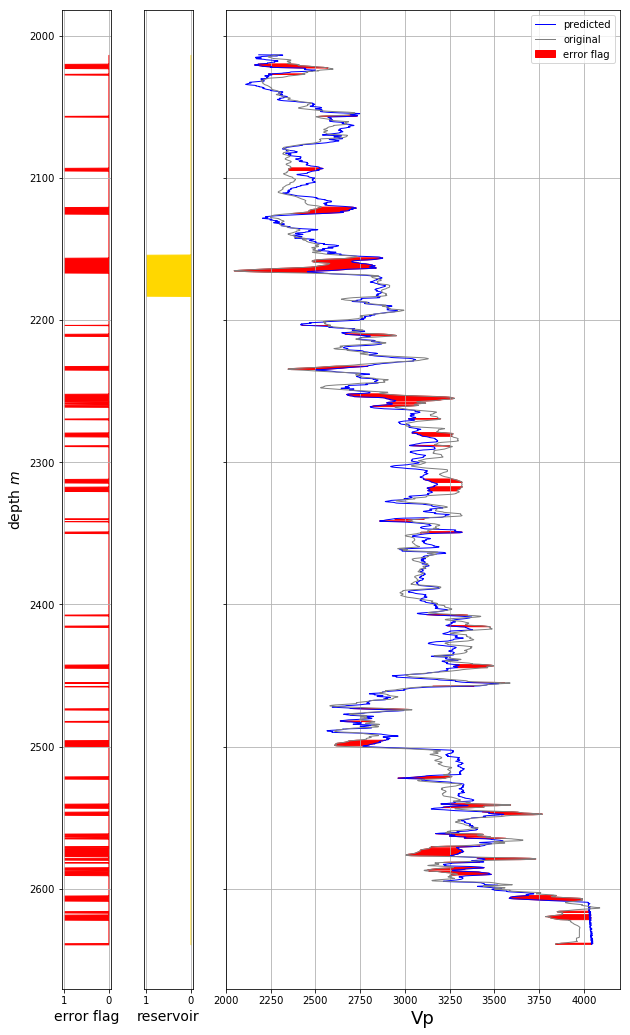

In [14]:
fig = plt.figure(figsize=(10,18))
gs = gridspec.GridSpec(1, 3, width_ratios=[0.5,0.5, 4]) 

ax = plt.subplot(gs[0])
ax.set_ylabel(r'depth $m$', size=14)
ax.fill_betweenx(logs2['DEPTH'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=14)
ax.grid()

ax1 = plt.subplot(gs[2])
ax1.plot(logs2["predictedVP"], logs2["DEPTH"], 'b', label='predicted', linewidth = 1)
ax1.plot(logs2["VP"], logs2["DEPTH"], 'gray', label='original', linewidth = 1)
ax1.set_xlim((2000, 4500))
ax1.fill_betweenx(logs2['DEPTH'], logs2["predictedVP"], logs2["VP"], where=flag==1, color = 'r', label='error flag')


ax2 = plt.subplot(gs[1])
ax2.fill_betweenx(logs2['DEPTH'],  0, logs2['oil_zone'],  color = 'gold')
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_yticks([])
ax2.set_xlabel('reservoir', size=14)
ax2.grid()

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('Vp', size=18)
ax1.set_xlim(2000,4200)

ax1.legend()   
ax1.grid();

#### Bonus: calculate RMS error and total number of flagged samples by zone

In [15]:
zones = list(logs2['ZONE_NUM'].unique())

In [16]:
rms = [np.sqrt(np.mean(logs2.loc[logs2.ZONE_NUM ==z, 'predictedVP'] -logs2.loc[logs2.ZONE_NUM ==z, 'VP'])** 2) for z in zones]
rms = np.array(rms)

In [17]:
zone_errors_df = pd.DataFrame({'zone': zones, 'RMS error': rms}).round(decimals=1)
zone_errors_df

,zone,RMS error
0,0,106.4
1,1,0.6
2,2,91.5
3,3,28.8
4,4,29.5
5,5,13.4
6,6,120.9
7,7,16.5
8,8,99.3
9,9,33.9


In [18]:
def flag_series(log, zone):
    """ returns amount of flagged portion of a zone"""    
    return np.sum(log[np.where(logs2['ZONE_NUM']== zone)])

In [19]:
zone_errors_df['flagged samples'] =  np.array([flag_series(flag, z)  for z in zones])
zone_errors_df

,zone,RMS error,flagged samples
0,0,106.4,20.0
1,1,0.6,8.0
2,2,91.5,44.0
3,3,28.8,0.0
4,4,29.5,245.0
5,5,13.4,12.0
6,6,120.9,27.0
7,7,16.5,110.0
8,8,99.3,31.0
9,9,33.9,61.0


### Third example (evaluate seismic inversion): error in acustic impedance from model based inversion

I will now use the error flag function to evaluate the quality of seismic inversion form a published article in the November 2009 CSEG Recorder [Inversion Driven Processing](https://csegrecorder.com/assets/pdfs/2009/2009-11-RECORDER-Inversion_Driven_Processing.pdf). 

The evaluation was done by the authors at a blind well location, but only qualitatively, as illustrated in Figure 5 in the paper, shown below. 

In the top panel (a) the evaluation is for the inversion without SPNA (Signal Protected Noise Attenuation); in the bottom panel (b) for the inversion with SPNA.

On the right side of each panel the inverted seismic trace is plotted against the upscaled impedance well log (calculated by multiplying the well density log and the well velocity log from compressional sonic); on the right, the upscaled impedance log is inserted in a seismic impedance section as a colored trace (at the location of the well) using the same color scale and range used for the impedance section.

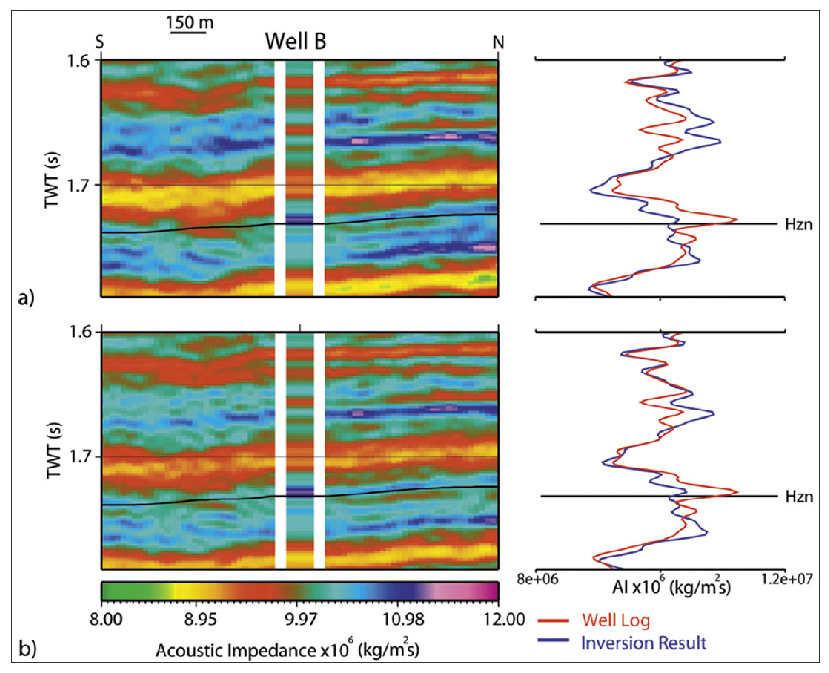

In [20]:
fig05=io.imread('../data/inversion_driven_processing_fig05.png')

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(fig05);

__Figure 5 caption__: _Acoustic impedance results at the blind well for data without (a) and with (b) SPNA. The figure shows a 200ms window of inverted seismic data with well B, the blind well, in the middle on the left, along with acoustic impedance curves for the well (red) and inverted seismic (blue) on the right. The data with SPNA shows a better fit to the well, particularly over the low frequencies_.

So, that's it: _"The data with SPNA shows a better fit to the well, particularly over the low frequencies"_. And this is stated, in this particular paper, without even a published R^2 comparison of the two methods.

In the remainder of the notebook I will try to do a quantitative comparison, using the error flag function. While at that I will also try to validate the claim that the trace with Signal Protected Noise Attenuation prior to inversion is a better match for the upscaled log.

The logs and inversion traces were hand-digitized (by me) from the figure above, so they will require interpolation to regularly-sampled time intervals; also (I'm being my own devil's advocate) small differences in the digitizing of curves in panel (a) vs panel (b) are inevitable, and will affect the error calculations, but I deem this a lesser evil.

The logs and inversio ntraces were hand-digitized (by me) from the figure above, so they will require interpolation to regularly-sampled time intervals.

In [21]:
log_a = np.loadtxt('../data/Recorder09_upscaled_log_a.csv', delimiter=',')[:,1]
log_a_t = np.loadtxt('../data/Recorder09_upscaled_log_a.csv', delimiter=',')[:,0]

In [22]:
log_b = np.loadtxt('../data/Recorder09_upscaled_log_b.csv', delimiter=',')[:,1]
log_b_t = np.loadtxt('../data/Recorder09_upscaled_log_b.csv', delimiter=',')[:,0]

In [23]:
inv_a = np.loadtxt('../data/Recorder09_inversion_a.csv', delimiter=',')[:,1]
inv_a_t = np.loadtxt('../data/Recorder09_inversion_a.csv', delimiter=',')[:,0]

In [24]:
inv_b = np.loadtxt('../data/Recorder09_inversion_b.csv', delimiter=',')[:,1]
inv_b_t = np.loadtxt('../data/Recorder09_inversion_b.csv', delimiter=',')[:,0]

In [25]:
fina = interpolate.interp1d(inv_a_t, inv_a)
finb = interpolate.interp1d(inv_b_t, inv_b)
floa = interpolate.interp1d(log_a_t, log_a)
flob = interpolate.interp1d(log_b_t, log_b)

time = np.arange(1.604, 1.8, 0.002)

ina = fina(time)
inb = finb(time)
loa = floa(time)
lob = flob(time)

In [26]:
result_a = pd.DataFrame({'time': time, 'ina': ina, 'loa': loa})
result_b = pd.DataFrame({'time': time, 'inb': inb, 'lob': lob})

I also digitized the position of the horizon.

In [27]:
hrzn = np.genfromtxt('../data/Recorder09_tops.csv', delimiter=',')[0, 1]
bttm = np.genfromtxt('../data/Recorder09_tops.csv', delimiter=',')[1, 1]

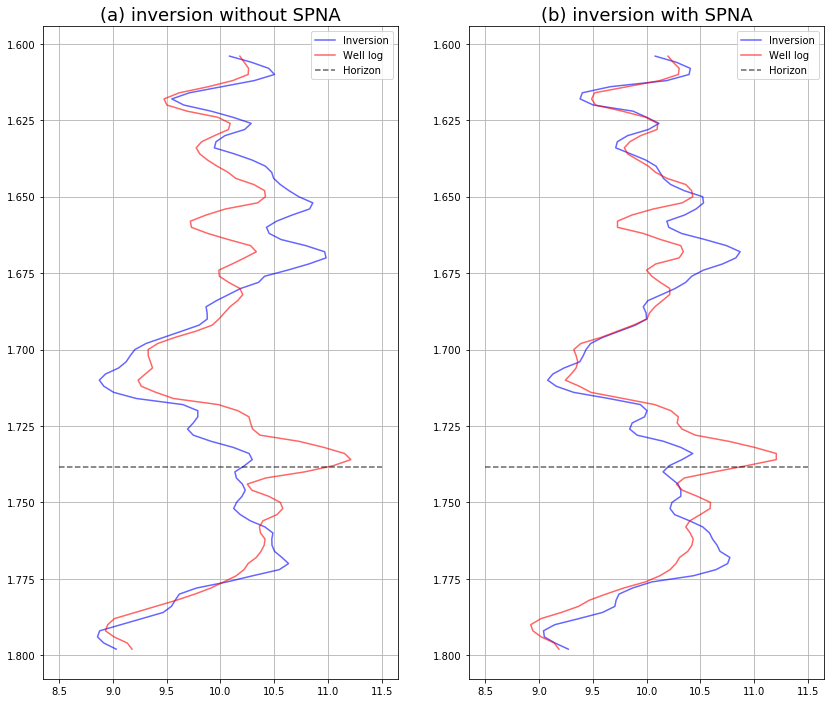

In [28]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(121)
ax1.plot(result_a.ina,result_a.time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(result_a.loa,result_a.time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [hrzn, hrzn], 'k--', alpha = 0.6, label = 'Horizon')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()
ax1.set_title('(a) inversion without SPNA', fontsize = 18)

ax2 = fig.add_subplot(122)
ax2.plot(result_b.inb,result_b.time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(result_b.lob,result_b.time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [hrzn, hrzn], 'k--', alpha = 0.6, label = 'Horizon')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()
ax2.set_title('(b) inversion with SPNA', fontsize = 18);


#### Comparing overall result of inversion without SPNA versus inversion with SPNA using RMS

In [29]:
rms_a = np.sqrt(np.mean((result_a.loa - result_a.ina) ** 2))
rms_b = np.sqrt(np.mean((result_b.lob - result_b.inb) ** 2))

print('RMS a = ', rms_a)
print('RMS b = ', rms_b)

RMS a =  0.3907630904840906
RMS b =  0.30069761181764454


Based on the single metric, it looks like case b, the inversion on Singal Protected Noise Attenuated data is the better result. This agrees with the observation that the curves on the right are closer to one another in several areas.

#### Comparing result of inversion without SPNA versus inversion with SPNA using flag (method 1)

In [30]:
flag_a = error_flag(result_a.ina, result_a.loa, 1)
flag_b = error_flag(result_b.inb, result_b.lob, 1)

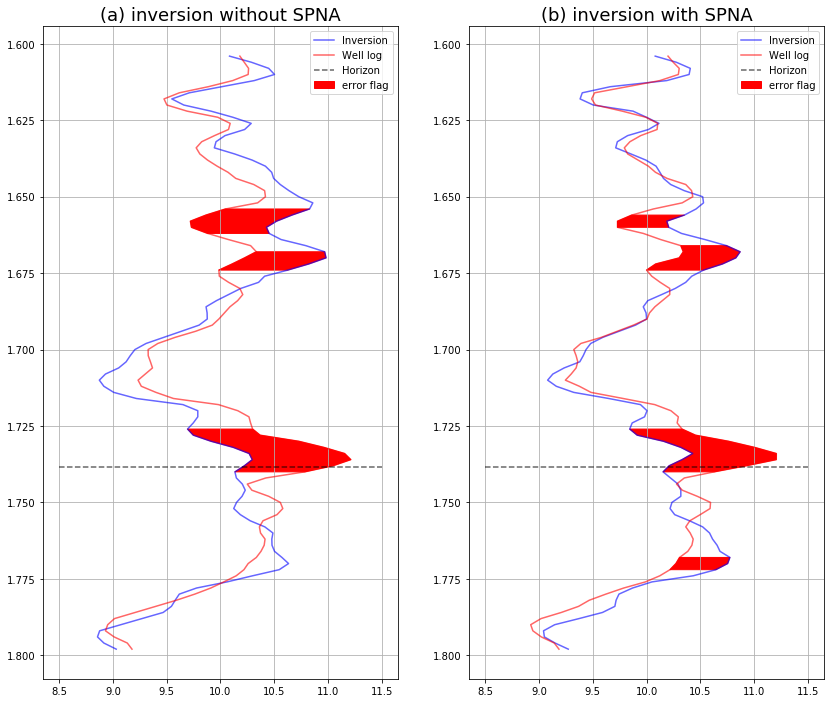

In [31]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(121)
ax1.plot(result_a.ina,result_a.time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(result_a.loa,result_a.time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [hrzn, hrzn], 'k--', alpha = 0.6, label = 'Horizon')
ax1.fill_betweenx(time, ina, loa, where=flag_a==1, color = 'r', label='error flag')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()
ax1.set_title('(a) inversion without SPNA', fontsize = 18)

ax2 = fig.add_subplot(122)
ax2.plot(result_b.inb,result_b.time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(result_b.lob,result_b.time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [hrzn, hrzn], 'k--', alpha = 0.6, label = 'Horizon')
ax2.fill_betweenx(time, inb, lob, where=flag_b==1, color = 'r', label='error flag')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()
ax2.set_title('(b) inversion with SPNA', fontsize = 18);

We can count the number of samples that have been flagged for each result (the code is adapted from [this Stack Overflow answer](https://stackoverflow.com/a/22353141)).

In [32]:
errors_a = list(sum(1 for _ in g) for k, g in groupby(flag_a) if k == 1.)
errors_b = list(sum(1 for _ in g) for k, g in groupby(flag_b) if k == 1.)

print('Number flagged samples a =', errors_a)
print('Number flagged samples b =', errors_b)

Number flagged samples a = [5, 4, 8]
Number flagged samples b = [3, 5, 8, 3]


Based on a local metric and the selected statitical significance for differences (1 standard deviation from the mean) it looks like in the area about 20 milliseconds below the horizon (I do not know if this is in the hydrocarbon reservoir or not) the original inversion (without SPNA) may be the better result. **NB I say 'maybe' because there's some uncertainty due to the fact that I digitized the curves by hand**.

#### Comparing result of inversion without SPNA versus inversion with SPNA using flag (method 3)¶

In [33]:
flag_a = error_flag(result_a.ina, result_a.loa, 1, 3)
flag_b = error_flag(result_b.inb, result_b.lob, 1, 3)

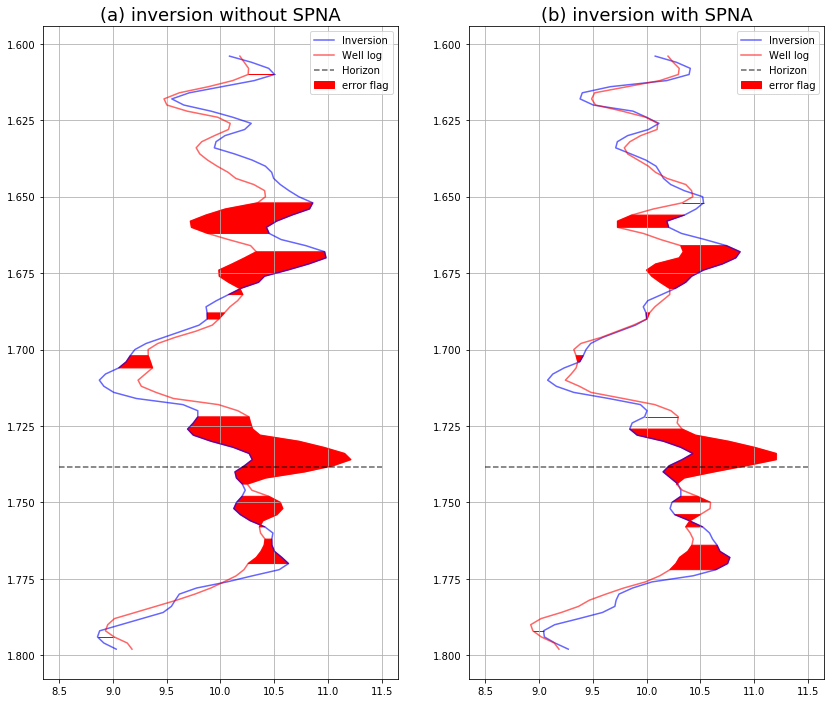

In [34]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(121)
ax1.plot(result_a.ina,result_a.time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(result_a.loa,result_a.time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [hrzn, hrzn], 'k--', alpha = 0.6, label = 'Horizon')
ax1.fill_betweenx(time, ina, loa, where=flag_a==1, color = 'r', label='error flag')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()
ax1.set_title('(a) inversion without SPNA', fontsize = 18)

ax2 = fig.add_subplot(122)
ax2.plot(result_b.inb,result_b.time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(result_b.lob,result_b.time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [hrzn, hrzn], 'k--', alpha = 0.6, label = 'Horizon')
ax2.fill_betweenx(time, inb, lob, where=flag_b==1, color = 'r', label='error flag')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()
ax2.set_title('(b) inversion with SPNA', fontsize = 18);

Again, we can count the number of samples that have been flagged for each result.

In [35]:
errors_a = list(sum(1 for _ in g) for k, g in groupby(flag_a) if k == 1.)
errors_b = list(sum(1 for _ in g) for k, g in groupby(flag_b) if k == 1.)

print('Number flagged samples a =', errors_a)
print('Number flagged samples b =', errors_b)

Number flagged samples a = [1, 6, 8, 2, 3, 12, 6, 5, 1]
Number flagged samples b = [1, 3, 8, 2, 2, 1, 10, 2, 3, 5, 1]


This seems more ambiguous, but if you looked closely at the zone at 1.750 seconds, you'd notice how small variation in the digitizing of the inversion likely affect the result, therefore invalidating its validity; however this is the only example with inversion I could find, and I am satisfied it is sufficient to illustrate the potential of the method.